# Understanding RL-PPO with (basic) cartpole

## Proximal Policy Optimization (PPO)

* Schulman et-al, Proximal Policy Optimization Algorithms, 2017, https://arxiv.org/pdf/1707.06347.pdf
* Schulman et-al, High-Dimensional Continuous Control Using Generalized Advantage Estimation, 2015, https://arxiv.org/pdf/1506.02438.pdf


### Xavier Bresson, xavier.bresson@gmail.com, https://twitter.com/xbresson

### Objectives
+ Understand RL-PPO algorithm from scratch, step-by-step, and as simple as possible
+ Code PPO for cartpole experiment (equivalent to MNIST for RL)

### Number of lines of code without description : 160


In [1]:
# Libraries
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import time
import gym # conda install -c conda-forge gym
           # pip install pygame (for video animation) with env = gym.make('CartPole-v0', render_mode="human")
import matplotlib
import matplotlib.pyplot as plt
from IPython import display


## Define (simplest) classes of policy/actor network and value/critic network


In [2]:
# class of policy/actor network
#  policy function : from state to probability of actions
#                    e.g. cartpole, state = 4-dim position, actions = {move left, move right}
class PolicyNetwork(nn.Module): 
    def __init__(self, net_parameters):
        super().__init__()
        self.linear1 = nn.Linear(net_parameters['input_dim'], net_parameters['hidden_dim'])
        self.linear2 = nn.Linear(net_parameters['hidden_dim'], net_parameters['hidden_dim'])
        self.linear3 = nn.Linear(net_parameters['hidden_dim'], 2) # two actions = {left, right}
    def forward(self, x):
        x = torch.relu(self.linear1(x))
        x = torch.relu(self.linear2(x))
        action_score = self.linear3(x) # size=[T,2]
        action_prob = torch.softmax(action_score, dim=1) # size=[T,2]
        return action_prob

# class of value/critic network  
#  value function : from state to value, with value = total (discarded) reward at the end of episode
#                    i.e. how much reward the agent is predicted to receive at the end of episode from the current state
#                    e.g. cartpole, value = (approximately) length to the end of episode
class ValueNetwork(nn.Module): 
    def __init__(self, net_parameters):
        super().__init__()
        self.linear1 = nn.Linear(net_parameters['input_dim'], net_parameters['hidden_dim'])
        self.linear2 = nn.Linear(net_parameters['hidden_dim'], net_parameters['hidden_dim'])
        self.linear3 = nn.Linear(net_parameters['hidden_dim'], 1) # scalar value
    def forward(self, x):
        x = torch.relu(self.linear1(x))
        x = torch.relu(self.linear2((x)))
        value_score = self.linear3((x))
        return value_score

# compute number of network parameters
def number_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    return nb_param

# network parameters
net_parameters = {}
net_parameters['input_dim'] = 4 # 4-dim position of cartpole
net_parameters['hidden_dim'] = 64
net_policy = PolicyNetwork(net_parameters)
net_value = ValueNetwork(net_parameters)
print('num_net_policy_parameters: %d' % number_param(net_policy) )
print('num_net_value_parameters: %d' % number_param(net_value) )


num_net_policy_parameters: 4610
num_net_value_parameters: 4545


## Rollout one episode


In [3]:
# rollout an episode
#  s_0 => a_0 ~ policy_net(s_0) => r_0, s_1 => a_1 ~ policy_net(s_1) => r_1, s_2 => ... 
#                                ... => s_t => a_t ~ policy_net(s_t) => r_t, s_t+1 => ... => end of episode 
def rollout_episode(env, net_policy, net_value):
    states=torch.tensor([]); next_states=torch.tensor([]); actions=torch.tensor([]).long(); rewards=torch.tensor([]); 
    log_probs=torch.tensor([]); values=torch.tensor([]); dones=torch.tensor([]).long()
    state = env.reset()[0] # reset environment before rolling out 
    max_t = 1000 # rollout one episode up to 1000 steps
    for t in range(max_t):
        # policy function
        state_pytorch = torch.from_numpy(state).float().unsqueeze(0) # state=s_t, t=0,1,...,T-1, T is episode length, size=[1,4]
        action_prob = net_policy(state_pytorch) # get action probabilities over dictionary of actions, size=[1,2]
        action = torch.multinomial(action_prob, num_samples=1).view(1) # sample action a_t, size=[1]  
        log_prob = torch.log(action_prob[:,action]).view(1).detach()   # get log probability log_p_t of the sampled action, size=[1]
        next_state, reward, done, _, _ = env.step(action.item())       # apply action and get next_state=s_t+1 and reward=r_t, len=[4], len=[1]
        done_mask = 0 if done else 1 # end of episode if done=True
        # value function
        value = net_value(state_pytorch).detach() # get value=V_t (estimated total discounted reward)
        # collect episode data in pytorch format    
        states = torch.cat( (states, state_pytorch), dim=0)  # size=[t+1,4], states = [s_0, s_1, s_2, ..., s_T-1] for last t=T-1
        next_states = torch.cat( (next_states, torch.tensor(next_state).unsqueeze(0)), dim=0) # size=[t+1,4], next_states = [s_1, s_2, s_3, ..., s_T] for last t=T-1 
        actions = torch.cat( (actions, action), dim=0)       # size=[t+1], states = [a_0, a_1, a_2, ..., a_T-1] for last t=T-1
        rewards = torch.cat( (rewards, torch.tensor(reward).view(1)), dim=0) # size=[t+1], rewards = [r_0, r_1, r_2, ..., r_T-1] for last t=T-1
        log_probs = torch.cat( (log_probs, log_prob), dim=0) # size=[t+1], log_probs = [log p_0, log p_1, ..., log p_T-1] for last t=T-1
        values = torch.cat( (values, value.view(1) ), dim=0) # size=[t+1], values = [V_0, V_1, V_2, ..., V_T-1] for last t=T-1
        dones = torch.cat( (dones, torch.tensor(done_mask).view(1)), dim=0) # size=[t+1], dones = [d_0=1, d_1, d_2, ..., d_T-1=0] for last t=T-1
        state = next_state                                   # update new state
        if done or t==max_t-1: # end of episode
            episode_length = t+1                             # length of episode
            break
    return episode_length, states, next_states, actions, rewards, log_probs, values, dones


env = gym.make('CartPole-v1')
episode_length, states, next_states, actions, rewards, log_probs, values, dones = rollout_episode(env, net_policy, net_value)
print('episode_length',episode_length)
print('states',states,states.size())
print('next_states',next_states,next_states.size())
print('actions',actions,actions.size())
print('rewards',rewards,rewards.size())
print('log_probs',log_probs,log_probs.size())
print('values',values,values.size())
print('dones',dones,dones.size())


episode_length 37
states tensor([[-2.3463e-03,  1.8660e-02,  1.4059e-02,  2.6370e-02],
        [-1.9731e-03, -1.7666e-01,  1.4586e-02,  3.2345e-01],
        [-5.5063e-03,  1.8250e-02,  2.1055e-02,  3.5407e-02],
        [-5.1413e-03,  2.1306e-01,  2.1763e-02, -2.5056e-01],
        [-8.8003e-04,  4.0787e-01,  1.6752e-02, -5.3630e-01],
        [ 7.2773e-03,  2.1252e-01,  6.0261e-03, -2.3838e-01],
        [ 1.1528e-02,  1.7308e-02,  1.2584e-03,  5.6193e-02],
        [ 1.1874e-02, -1.7783e-01,  2.3822e-03,  3.4927e-01],
        [ 8.3171e-03,  1.7256e-02,  9.3677e-03,  5.7342e-02],
        [ 8.6622e-03,  2.1224e-01,  1.0515e-02, -2.3237e-01],
        [ 1.2907e-02,  1.6971e-02,  5.8671e-03,  6.3610e-02],
        [ 1.3247e-02, -1.7823e-01,  7.1393e-03,  3.5814e-01],
        [ 9.6818e-03, -3.7346e-01,  1.4302e-02,  6.5306e-01],
        [ 2.2127e-03, -1.7854e-01,  2.7363e-02,  3.6492e-01],
        [-1.3581e-03,  1.6186e-02,  3.4662e-02,  8.0988e-02],
        [-1.0343e-03,  2.1079e-01,  3.6281e-0

## Train policy network and value network


Epoch: 100, time: 23.3553, train_loss: 354.2332, mean_episode_length: 695.4500


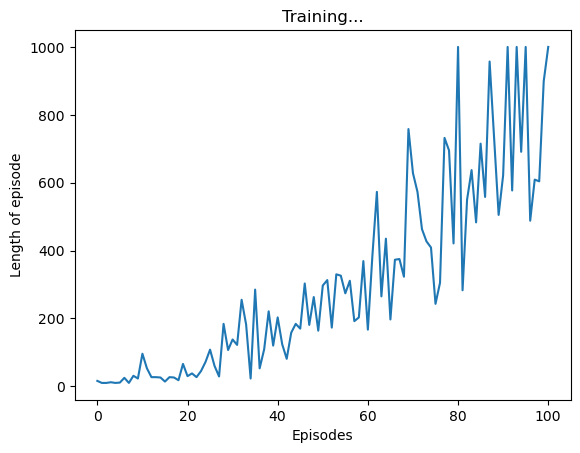

In [8]:
# train the policy and value networks with one episode
def train_policy_value_networks(opt_parameters, net_policy, net_value, optimizer_policy, optimizer_value, \
                                states, next_states, actions, rewards, log_probs, values, dones):

    # optimization parameters
    gamma = opt_parameters['gamma']
    beta = opt_parameters['beta']
    num_iter_value_loss = opt_parameters['num_iter_value_loss'] 
    num_iter_policy_loss = opt_parameters['num_iter_policy_loss'] 
    clip_value = opt_parameters['clip_value'] 
    
    # Update value network in 2 steps
    #  Step 1 : Compute discounted rewards at each time t for the whole episode
    discounted_reward_t_plus_one = torch.tensor([0]) # r_t+1=r_T=0 for t=T-1, T=length of episode
    discounted_rewards = torch.tensor([]) # collect discounted rewards
    for r_t in rewards.tolist()[::-1]: # compute discounted reward (dr) in reverse time, from t=T-1, T-2, ..., 0
                                       # i.e. rewards[::-1] = [r_T-1, r_T-2, r_T-3, ..., r_1, r_0]
                                       # why reversed? recursive equation is fast : dr_t = r_t + g * dr_t+1, g = gamma
        discounted_reward_t = torch.tensor(r_t) + gamma * discounted_reward_t_plus_one # scalar
         #             dr_t = r_t + g * dr_{t+1}
         #  t=T-1 => dr_T-1 = r_T-1 + g * dr_T=0 = r_T-1
         #  t=T-2 => dr_T-2 = r_T-2 + g * dr_T-1
         #                  = r_T-2 + g * r_T-1
         #  t=T-3 => dr_T-3 = r_T-3 + g * dr_T-2
         #                  = r_T-3 + g * (r_T-2 + g* r_T-1)
         #                  = r_T-3 + g * r_T-2 + g^2* r_T-1
         #                  etc 
         #  t=0   =>   dr_0 = r_0 + g * r_1 + ... + g^T-1 r_T-1  
        discounted_rewards = torch.cat( (discounted_reward_t, discounted_rewards), dim=0) # size=[t+1], discounted_rewards = [dr_0, dr_1, ..., dr_T-1] for last t=0          
        discounted_reward_t_plus_one = discounted_reward_t # update discounted reward   
    #  Step 2 : Compute loss between predicted value and the episode discounted reward
    #           Note : states and discounted_rewards collected from the episode are fixed during optimization
    #
    # Loss_value = mean_{t=0}^{T-1} || V_phi_t - dr_t ||^2, V_phi_t = net_value(state_t), scalar
    #
    #                                       with dr_t = sum_{l=0} gamma^l r_t+l
    #
    # min Loss_value => V_phi_t ~ dr_t
    #
    for _ in range(num_iter_value_loss):
        optimizer_value.zero_grad() 
        pred_values = net_value(states).squeeze() # size=[T]
        loss_value = ( (pred_values - discounted_rewards.detach())**2 ).mean() # MSE, scalar
        loss_value.backward()
        optimizer_value.step()
    loss_value = loss_value.detach().item() # for print
        
    # Update policy network in 2 steps
    #  Step 1 : Compute advantage values at each time step for the whole episode
    V_t = values # V_t = [V_0, V_1, V_2, ..., V_T-1], size=[T]
    V_t_plus_one = torch.cat((V_t[1:],torch.tensor([0])),dim=0) # V_t+1 = [V_1, V_2, ..., V_T=0], size=[T]
    deltas = rewards + gamma * V_t_plus_one - V_t # deltas = [delta_0, delta_1, ..., delta_T-1], delta_t = r_t + gamma * V_t+1 - V_t, size=[T]
    advantage_t_plus_one = torch.tensor([0])      # A_t+1=0 for t=T-1
    advantages = torch.tensor([]) # collect advantage values
    for delta_t in deltas.tolist()[::-1]: # compute the generalized advantage estimator at each time step
                                          # deltas[::-1] = [delta_T-1, delta_T-2, ..., delta_1, delta_0]
                                          # why reversed? recursive equation is fast :  A_t = delta_t + gamma * beta * A_t+1  
        advantage_t = torch.tensor(delta_t) + gamma * beta * advantage_t_plus_one 
        advantages = torch.cat( (advantage_t, advantages), dim=0) # size=[t+1], advantages = [A_0, A_1, ..., A_T-1] for last t=0          
        advantage_t_plus_one = advantage_t
    #  Step 2 : Compute clipped trust region loss for policy network
    #           Note : states, actions, previous log_probs and advantages collected from the episode are fixed during optimization
    #
    # Loss_policy = - mean_{t=0}^{T-1} ( min( ratio_t * A_t , clip(ratio_t) * A_t ) )
    # 
    #             with ratio_t = Policy_Net(a_t|s_t) / Policy_Net_previous(a_t|s_t), Policy_Net = Probability
    #
    #                      A_t = sum_{l=0} (gamma * beta)^l delta_t+l, delta_t = r_t + gamma * V_t+1 - V_t
    #
    #            clip(ratio_t) = max( 1 - clip_value , min(ratio_t, 1 + clip_value) )
    #
    # min Loss_policy => max Policy_Net(a_t|s_t) * A_t with Policy_Net better than Policy_Net_previous
    #                         
    #                                                   and clipping limits the variations of Policy_Net
    #
    #                    max Policy_Net(a_t|s_t) * A_t => select action that long-term reward
    #
    log_probs_previous = log_probs # use log_probs from episode (fixed during optimization), size=[T]
    for _ in range(num_iter_policy_loss):
        optimizer_policy.zero_grad()
        action_prob = net_policy(states) # get action probabilities over dictionary of actions, size=[T,2]
        log_probs = torch.log( action_prob[torch.arange(actions.size(0)), actions] ) # use actions from episode (no sampling), size=[T]
        policy_ratio = torch.exp( log_probs - log_probs_previous.detach()) # ratio between new optimized policy and previous one, size=[T]
        clipped_ratio = policy_ratio.clamp(1.0 - clip_value, 1.0 + clip_value) # clipped ratio to allow small changes only, size=[T]
        loss_policy = - torch.min( policy_ratio * advantages , clipped_ratio * advantages ).mean() # select the loss with smallest change, scalar
        loss_policy.backward()
        optimizer_policy.step()
    policy_losses = loss_policy.detach().item() # for print
#         kl_div = (log_probs - log_probs_previous).detach().mean()
#         if kl_div >= 0.02:
#             break
    return loss_policy, loss_value
    

# instantiate the networks
#del net_policy, net_value
net_parameters = {}
net_parameters['input_dim'] = 4
net_parameters['hidden_dim'] = 64
net_policy = PolicyNetwork(net_parameters)
net_value = ValueNetwork(net_parameters)
print('num_net_policy_parameters: %d' % number_param(net_policy) )
print('num_net_value_parameters: %d' % number_param(net_value) )

# optimization parameters
opt_parameters = {}
opt_parameters['lr_net_policy'] = 3e-4
opt_parameters['lr_net_value'] = 1e-3
opt_parameters['gamma'] = 0.99
opt_parameters['beta'] = 0.97
opt_parameters['clip_value'] = 0.2 
opt_parameters['num_iter_value_loss'] = 40
opt_parameters['num_iter_policy_loss'] = 40
optimizer_policy = torch.optim.Adam(net_policy.parameters(), lr=opt_parameters['lr_net_policy'] )
optimizer_value = torch.optim.Adam(net_value.parameters(), lr=opt_parameters['lr_net_value'] )

# environment
env = gym.make('CartPole-v1')
env._max_episode_steps = 400 # increase the default max_episode_steps from 100 to 400 (100 is too easy)

# training
all_epoch_lengths = [] # plot
start = time.time()
num_episodes = 101
for epoch in range(num_episodes): 
    
    # train with one episode
    episode_length, states, next_states, actions, rewards, log_probs, values, dones = \
      rollout_episode(env, net_policy, net_value) # roll-out one episode
    loss_policy, loss_value = \
      train_policy_value_networks(opt_parameters, net_policy, net_value, optimizer_policy, optimizer_value, \
                                  states, next_states, actions, rewards, log_probs, values, dones) # train networks with the new episode

    # print intermediate stats
    if not epoch%10:
        print('Epoch: {}, time: {:.4f}, train_loss: {:.4f}, mean_episode_length: {:.4f}'.format(epoch, time.time()-start, loss_policy + loss_value, torch.Tensor(all_epoch_lengths)[-20:].mean().item()))
        
    # plot all epochs
    all_epoch_lengths.append(episode_length)
    if not epoch%10:
        plt.figure(2)
        plt.title('Training...')
        plt.xlabel('Episodes')
        plt.ylabel('Length of episode')
        plt.plot(torch.Tensor(all_epoch_lengths).numpy())
        plt.pause(0.001)
        display.clear_output(wait=True)
        

## Video animation


In [ ]:
env = gym.make('CartPole-v1', render_mode="human")
env._max_episode_steps = 5000
state = env.reset()[0] # reset environment
for t in range(env._max_episode_steps): # rollout one episode 
    state_pytorch = torch.from_numpy(state).float().unsqueeze(0) # state=s_t
    action = Categorical(net_policy(state_pytorch)).sample() # sample action a_t
    state, _, done, _, _ = env.step(action.item()) # apply action and get next_state=s_t+1
    env.render() # visualize state
    if done:
        print(t)
        break
        